# Машинное обучение, ФКН ВШЭ

## Практическое задание 6. Разложение ошибки на смещение и разброс

### Общая информация

Дата выдачи: 20.11.2020

Мягкий дедлайн: 00:59MSK 02.12.2019

Жесткий дедлайн: 00:59MSK 07.12.2019

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-06-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

В этом задании вам предстоит воспользоваться возможностями бутстрапа для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston:

__Оценка:__ 10

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
from sklearn.datasets import load_boston

In [3]:
boston = load_boston()

In [4]:
X = boston["data"]
y = boston["target"]

In [5]:
X.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [6]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

34.01288157491277

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$. 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки: 
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__1. (3 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [7]:
def compute_biase_variance(regressor, X, y, num_runs=200):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)
    
    :returns: bias (float), variance (float), error (float) 
    each value is computed using bootstrap
    """
    from sklearn.utils import resample
    
    preds = []
    
    for i in range(num_runs):
        sample = resample(range(X.shape[0]), replace=True, n_samples=X.shape[0])
        test_sample = np.delete(np.array([range(X.shape[0])]), sample)
        y_pred = regressor.fit(X[sample], y[sample]).predict(X[test_sample])
        cur_sample = np.empty(X.shape[0])
        cur_sample.fill(np.nan)
        np.put(cur_sample, test_sample, y_pred)
        preds.append(cur_sample)
    
    preds = np.asarray(preds).T    
    bias = np.nanmean((np.nanmean(preds, axis=1) - y)**2)
    variance = np.nanmean(np.nanvar(preds, axis=1))
    error = np.nanmean((preds - np.tile(np.array([y]).T, (1, num_runs)))**2)
    
    return bias, variance, error

__2. (0 баллов)__

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

print('Расчет смещения, разброса и ошибки...')
print('Результат для LR:',compute_biase_variance(LinearRegression(),X,y))
print('Результат для DT:',compute_biase_variance(DecisionTreeRegressor(),X,y))
print('Результат для RF:',compute_biase_variance(RandomForestRegressor(),X,y))

Расчет смещения, разброса и ошибки...
Результат для LR: (23.794209409633407, 0.9170828139522549, 24.451289485595947)
Результат для DT: (10.609166984704974, 12.949308125527754, 23.69978079918636)
Результат для RF: (10.540845777115903, 2.2342923419410483, 12.74417552118712)


__3. (1 балл)__
Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на занятиях (с комментарием)?

Да, результаты согласуются с тем, что обсуждалось на лекциях: 
- Наибольшее смещение наблюдается у линейной регрессии, однако разброс у нее минимален
- У решающего дерева наоборот - минимальное смещение и наибольший разброс (высокая вероятность переобучения)
- Случайный лес минимизировал недостатки решеающего дерева, уменьшив разброс при практически неизменном смещении

__4. (1 балл)__
Постройте бэггинг над всеми тремя моделями (линейная регрессия, решающее дерево, случайный лес). Вспомните обсуждение с лекции о том, во сколько раз в теории бэггинг уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.

- На лекции было доказано, что бэггинг уменьшает разброс модели в N раз, где N - это число алгоритмов (при условии  некоррелированности их ответов!)
- В библиотеке sklearn дефолтное N=10, т.е. разброс каждого из алгоритмов должен был уменьшится в 10 раз
- По факту мы видим, что разброс линейной регрессии остался практически неизменным (в принципе он и был небольшим), а для решающего дерева и случайного леса - уменьшился в несколько раз, но значительно меньше ожидаемого 10, что связано с коррелированностью ответов алгоритмов

In [9]:
from sklearn.ensemble import BaggingRegressor

print('Расчет смещения, разброса и ошибки...')
print('Результат для LR:',compute_biase_variance(BaggingRegressor(base_estimator=LinearRegression()),X,y))
print('Результат для DT:',compute_biase_variance(BaggingRegressor(base_estimator=DecisionTreeRegressor()),X,y))
print('Результат для RF:',compute_biase_variance(BaggingRegressor(base_estimator=RandomForestRegressor()),X,y))


Расчет смещения, разброса и ошибки...
Результат для LR: (23.800099314039745, 0.9850184605817339, 24.872427766200325)
Результат для DT: (10.72924610886854, 3.2934669320107774, 13.987062046645985)
Результат для RF: (11.516288537241424, 1.3354904899723394, 13.04981916709345)


### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__5. (2 балла)__

Реализуйте фукнцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [10]:
def plot_predictions(regressor, X, y, num_runs=100, num_test_objects=10, title=""):
    """
    plot graphics described above
    """
    from sklearn.utils import resample
    
    # step 1
    test = resample(range(X.shape[0]), replace=False, n_samples=num_test_objects)
    train = np.delete(np.array([range(X.shape[0])]), test)
    X_test = X[test]
    y_test = y[test]
    X_train = X[train]
    y_train = y[train]
    
    # step 2
    for i in range(num_runs):
        sample = resample(range(X_train.shape[0]), replace=True, n_samples=X_train.shape[0])
        regressor.fit(X_train[sample], y_train[sample])
        y_pred = regressor.predict(X_test) 
        
        # step 3
        plt.scatter(range(num_test_objects), y_pred, alpha=0.3, c = 'skyblue')
     
    # step 4
    plt.scatter(np.arange(num_test_objects), y_test, c = 'black')
    plt.xlabel('num_test_objects')
    plt.ylabel('prediction') 
    plt.title(title)


__6. (0 баллов)__

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

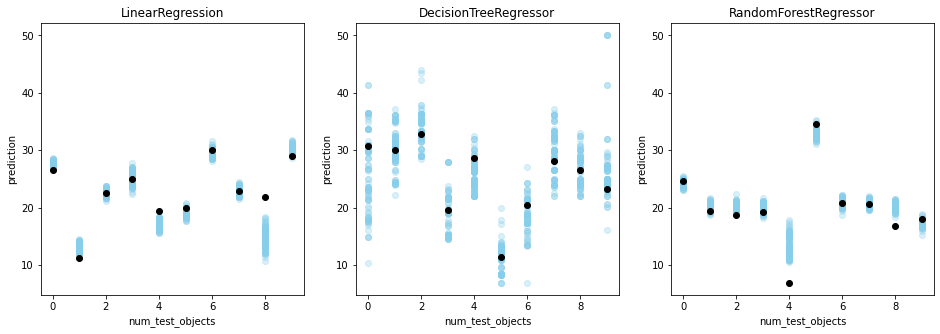

In [11]:
plt.figure(figsize=(16, 5))
ax1 = plt.subplot(1, 3, 1)
plot_predictions(LinearRegression(),X,y,title="LinearRegression")
ax2 = plt.subplot(1, 3, 2, sharey=ax1)
plot_predictions(DecisionTreeRegressor(),X,y,title="DecisionTreeRegressor")
ax3 = plt.subplot(1, 3, 3, sharey=ax1)
plot_predictions(RandomForestRegressor(),X,y,title="RandomForestRegressor")

__7. (1 балл)__

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма. 

1) LinearRegression:
- Наблюдаем наибольшее отклонение черных точек (истинных ответов) от голубых столбиков (предсказаний), что объясняет высокий уровень смещения, однако разброс у данной модели минимален, что характеризует небольшая высота голубых столбиков

2) DecisionTreeRegressor:
- Видим минимальное смещение - истинные ответы попали практически в центр столбиков, и наибольший разброс, исходя из разреженности и высоты столбиков

3) RandomForestRegressor:
- Смещение практически не уступает решающему дереву, разброс модели в сравнении с решающим деревом уменьшен

### Изменение bias и variance при изменении гиперпараметров

__8. (0 баллов)__

Постройте графики зависимости смещения и разброса от гиперпараметров решающего дерева max_depth (от 1 до 10) и max_features (от 1 до X.shape[1]):

In [19]:
md_thresholds, mf_thresholds, biases, variances = [[] for i in range(4)]

for k, max_depth in enumerate(range(1,11)):
    for j, max_features in enumerate(range(1,X.shape[1]+1)):
        md_thresholds.append(max_depth)
        mf_thresholds.append(max_features)
        results = compute_biase_variance(DecisionTreeRegressor(max_depth=max_depth, max_features=max_features, random_state=1), X, y)
        biases.append(results[0])
        variances.append(results[1])


In [20]:
df = pd.DataFrame([])
df['max_depth'] = md_thresholds
df['max_features'] = mf_thresholds
df['biases'] = biases
df['variances'] = variances
df.head()

,max_depth,max_features,biases,variances
0,1,1,45.599543,4.504109
1,1,2,45.801356,4.540875
2,1,3,45.916185,4.193584
3,1,4,45.830861,4.585807
4,1,5,45.696286,4.570844


Text(0.5, 1.0, 'Зависимость смещения от максимальной глубины и числа фичей')

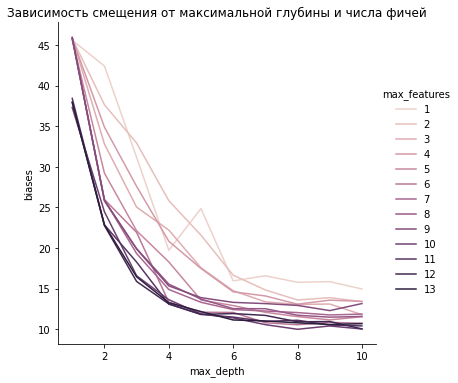

In [21]:
import seaborn as sns

# График №1
sns.relplot(data=df, x="max_depth", y="biases", hue="max_features", kind="line", legend="full")
plt.title('Зависимость смещения от максимальной глубины и числа фичей')

Text(0.5, 1.0, 'Зависимость разброса от максимальной глубины и числа фичей')

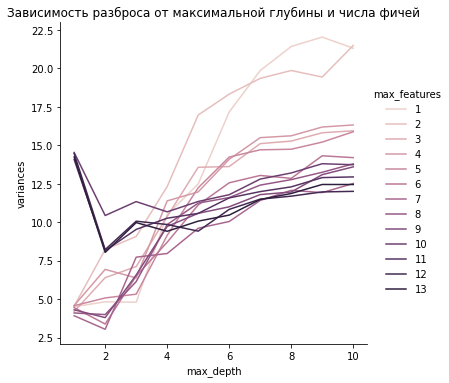

In [22]:
# График №2
sns.relplot(data=df, x="max_depth", y="variances", hue="max_features", kind="line", legend="full")
plt.title('Зависимость разброса от максимальной глубины и числа фичей')

__9. (0 баллов)__

Постройте графики зависимости смещения и разброса от n_estimators (по сетке 2**np.arange(1, 10)) для случайного леса и градиентного бустинга:

In [16]:
from sklearn.ensemble import GradientBoostingRegressor

n_thresholds, biases_rf, biases_gb, variances_rf, variances_gb = [[] for i in range(5)]

for i, n_estimators in enumerate(2**np.arange(1,10)):
    n_thresholds.append(n_estimators)
    results_rf = compute_biase_variance(RandomForestRegressor(n_estimators=n_estimators, random_state=1), X, y, num_runs=100)
    results_gb = compute_biase_variance(GradientBoostingRegressor(n_estimators=n_estimators, random_state=1), X, y, num_runs=100)
    biases_rf.append(results_rf[0])
    variances_rf.append(results_rf[1])
    biases_gb.append(results_gb[0])
    variances_gb.append(results_gb[1])

df2 = pd.DataFrame([])
df2['n_thresholds'] = n_thresholds
df2['biases_rf'] = biases_rf
df2['biases_gb'] = biases_gb
df2['variances_rf'] = variances_rf
df2['variances_gb'] = variances_gb
df2.head()

,n_thresholds,biases_rf,biases_gb,variances_rf,variances_gb
0,2,10.400074,62.468324,7.940234,0.393191
1,4,11.080314,47.129420,5.222541,0.633460
2,8,10.545173,29.819796,3.643526,0.946166
3,16,10.633596,16.558554,2.941875,1.375534
4,32,10.600157,11.329297,2.392740,1.657525


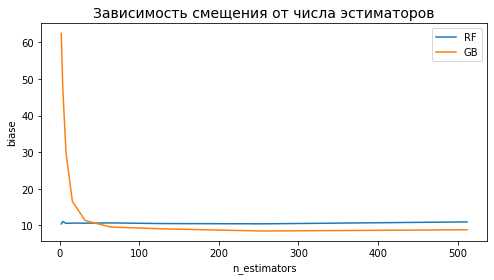

In [24]:
# График №3
plt.figure(figsize=(8, 4))
plt.plot(df2.n_thresholds, df2.biases_rf, label='RF')
plt.plot(df2.n_thresholds, df2.biases_gb, label='GB')
plt.title('Зависимость смещения от числа эстиматоров', fontsize = 14)
plt.xlabel('n_estimators')
plt.ylabel('biase')
plt.legend()
plt.show()

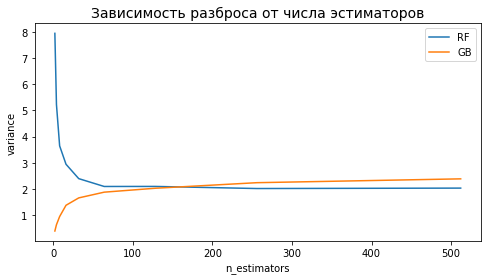

In [23]:
# График №4
plt.figure(figsize=(8, 4))
plt.plot(df2.n_thresholds, df2.variances_rf, label='RF')
plt.plot(df2.n_thresholds, df2.variances_gb, label='GB')
plt.title('Зависимость разброса от числа эстиматоров', fontsize = 14)
plt.xlabel('n_estimators')
plt.ylabel('variance')
plt.legend()
plt.show()

__10. (2 балла)__

Прокомментируйте графики (всего 4 графика): почему они имеют такой вид.

__Your answer here:__
- (график 1) при дефолтных настройках (max_depth=None) дерево склонно подстраиваться под ответы обучающей выборки, поэтому при больших значениях этих параметров смещение алгоритма будет минимально, а при их уменьшении - будет падать, что как раз можно увидеть на графиках; уменьшение max_features дает больше шума в данные, за счет чего смещение начинает расти


- (график 2) изначально (при неограниченной глубине дерева) алгоритм имеет высокую степень разброса, связанную с переобучением, как только мы начинаем ограничивать этот параметр - разброс начинает падать (но до определенного разумного параметра, как можно увидеть на графике); уменьшение max_features прибавляет шума в данные, за счет чего разброс для 1го дерева начинает расти



- (график 3) случайный лес сам по себе имеет небольшое смещение, поэтому изменение параметра на нем существенно не отразилось, в отличие от градиентного бустинга - начиная где-то с n_estimators==50 видим значительное улучшение алгоритма


- (график 4) случайный лес начиная с определенного момента уже не получает прироста в качестве, а градиентный бустинг начиная определенного числа начал сильно переобучаться - разброс начинает расти